# Let's Build a Quant Trading Strategy

## Video 1: Build a ML Model in PyTorch

In [3]:
# https://github.com/memlabs-research/build-a-quant-trading-strategy

In [4]:
# y_hat = model(x)
# orders = strategy(y_hat)
# execute(orders)

In [5]:
# regression model => BTCUSDT => future log return

In [6]:
# Data and analysis libraries
import polars as pl                         # Fast dataframes for financial data
import numpy as np                          # Numerical computing library
from datetime import datetime, timedelta    # Date and time operations
import random


# Machine learning libraries  
import torch                                # PyTorch framework
import torch.nn as nn                       # Neural network modules
import torch.optim as optim                 # Optimization algorithms
import research                             # Model building and training utilities


# Visualization and 
import altair as alt                        # Interactive visualization library

# data sources
import binance                              # Binance market data utilities

In [7]:
research.set_seed(42)

In [8]:
pl.Config.set_tbl_width_chars(200)
pl.Config.set_fmt_str_lengths(100)
pl.Config.set_tbl_cols(-1)  # Show all columns

polars.config.Config

In [9]:
# Trading pair symbol
sym = 'BTCUSDT'
# Historical data window in days (e.g., 6 months)            
hist_data_window = 7 * 4 * 6
# time horizon of time series (time interval)
time_interval = '1h'
# Max number of auto-regressive lags
max_lags = 4
# Forecast horizon in steps 
forecast_horizon = 1
# Sharpe annualized rate (so it's independent of time frequency)
annualized_rate = research.sharpe_annualization_factor(time_interval, 365, 24)

In [10]:
binance.download_trades(sym, hist_data_window)

[ERROR] BTCUSDT 2025-10-22: ('Connection broken: IncompleteRead(38173617 bytes read, 4073930 more expected)', IncompleteRead(38173617 bytes read, 4073930 more expected))


In [11]:
ts = research.load_ohlc_timeseries(sym, time_interval)
ts

Loading BTCUSDT:   0%|          | 0/168 [00:00<?, ?file/s]

Loading BTCUSDT: 100%|██████████| 168/168 [00:26<00:00,  6.37file/s]


datetime,open,high,low,close
datetime[μs],f64,f64,f64,f64
2025-05-07 00:00:00,96798.9,97476.9,96716.1,97379.6
2025-05-07 01:00:00,97379.5,97700.0,97150.0,97208.6
2025-05-07 02:00:00,97208.7,97245.1,96412.3,96582.3
2025-05-07 03:00:00,96582.4,96623.0,96153.2,96453.8
2025-05-07 04:00:00,96453.8,96655.8,96371.0,96527.6
…,…,…,…,…
2025-10-21 19:00:00,111934.5,112147.4,111501.7,111720.7
2025-10-21 20:00:00,111720.7,111747.7,110468.0,110733.0
2025-10-21 21:00:00,110733.0,111068.7,110016.3,110772.6


In [12]:
research.load_timeseries(sym, time_interval, pl.col('price').quantile(0.5).alias('price_median'))

Loading BTCUSDT: 100%|██████████| 168/168 [00:25<00:00,  6.65file/s]


datetime,price_median
datetime[μs],f64
2025-05-07 00:00:00,97142.4
2025-05-07 01:00:00,97422.0
2025-05-07 02:00:00,96844.5
2025-05-07 03:00:00,96406.8
2025-05-07 04:00:00,96525.8
…,…
2025-10-21 19:00:00,111785.2
2025-10-21 20:00:00,110873.7
2025-10-21 21:00:00,110651.2


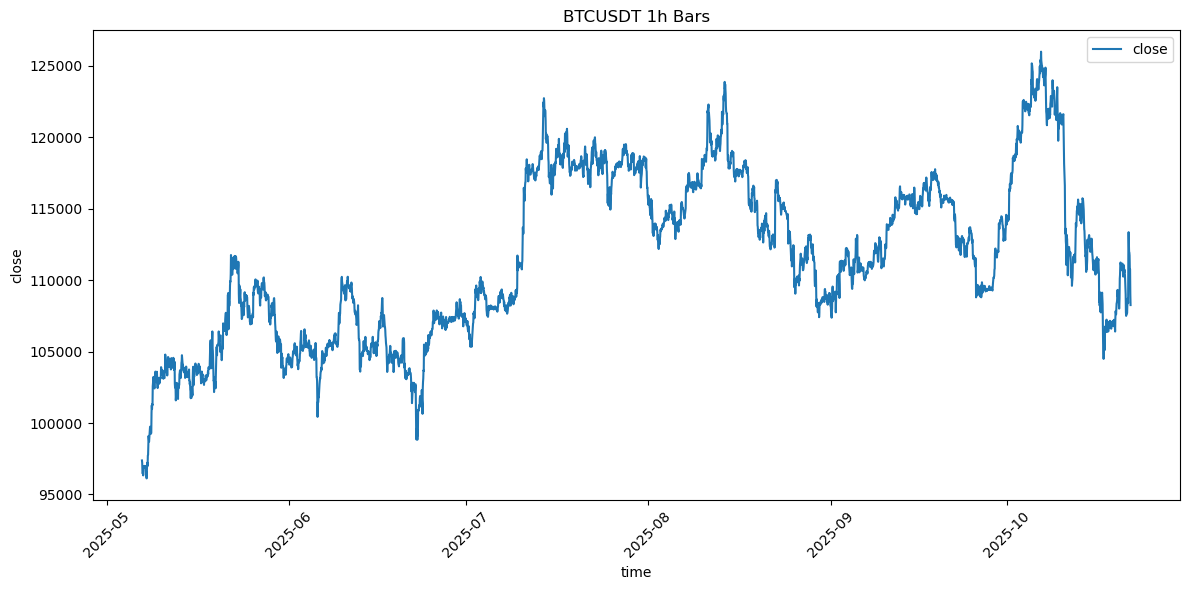

In [13]:
research.plot_static_timeseries(ts, sym, 'close', time_interval)

In [14]:
alt.data_transformers.enable("vegafusion")
research.plot_dyn_timeseries(ts, sym, 'close', time_interval)

alt.Chart(...)

### Feature Engineering

In [15]:
price_time_series = pl.DataFrame({'price':[100.0,120.0,100.0]})
research.plot_column(price_time_series, 'price')

alt.Chart(...)

In [16]:
price_time_series.with_columns(
    pl.col('price').diff().alias('delta'),
    ((pl.col('price')-pl.col('price').shift())/pl.col('price').shift()).alias('return'),
    (pl.col('price')/pl.col('price').shift()).log().alias('log_return'),
)

price,delta,return,log_return
f64,f64,f64,f64
100.0,null,null,null
120.0,20.0,0.2,0.182322
100.0,-20.0,-0.166667,-0.182322


### Create target and lagged features

In [17]:
ts = ts.with_columns((pl.col('close')/pl.col('close').shift(forecast_horizon)).log().alias('close_log_return'))
ts

datetime,open,high,low,close,close_log_return
datetime[μs],f64,f64,f64,f64,f64
2025-05-07 00:00:00,96798.9,97476.9,96716.1,97379.6,null
2025-05-07 01:00:00,97379.5,97700.0,97150.0,97208.6,-0.001758
2025-05-07 02:00:00,97208.7,97245.1,96412.3,96582.3,-0.006464
2025-05-07 03:00:00,96582.4,96623.0,96153.2,96453.8,-0.001331
2025-05-07 04:00:00,96453.8,96655.8,96371.0,96527.6,0.000765
…,…,…,…,…,…
2025-10-21 19:00:00,111934.5,112147.4,111501.7,111720.7,-0.001912
2025-10-21 20:00:00,111720.7,111747.7,110468.0,110733.0,-0.00888
2025-10-21 21:00:00,110733.0,111068.7,110016.3,110772.6,0.000358


In [18]:
target = 'close_log_return'
lr = pl.col(target)
ts = ts.with_columns(
    lr.shift(forecast_horizon * 1).alias(f'{target}_lag_1'),
    lr.shift(forecast_horizon * 2).alias(f'{target}_lag_2'),
    lr.shift(forecast_horizon * 3).alias(f'{target}_lag_3'),
    lr.shift(forecast_horizon * 4).alias(f'{target}_lag_4'),
)
ts

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-05-07 00:00:00,96798.9,97476.9,96716.1,97379.6,null,null,null,null,null
2025-05-07 01:00:00,97379.5,97700.0,97150.0,97208.6,-0.001758,null,null,null,null
2025-05-07 02:00:00,97208.7,97245.1,96412.3,96582.3,-0.006464,-0.001758,null,null,null
2025-05-07 03:00:00,96582.4,96623.0,96153.2,96453.8,-0.001331,-0.006464,-0.001758,null,null
2025-05-07 04:00:00,96453.8,96655.8,96371.0,96527.6,0.000765,-0.001331,-0.006464,-0.001758,null
…,…,…,…,…,…,…,…,…,…
2025-10-21 19:00:00,111934.5,112147.4,111501.7,111720.7,-0.001912,-0.000229,-0.004875,-0.007509,0.01089
2025-10-21 20:00:00,111720.7,111747.7,110468.0,110733.0,-0.00888,-0.001912,-0.000229,-0.004875,-0.007509
2025-10-21 21:00:00,110733.0,111068.7,110016.3,110772.6,0.000358,-0.00888,-0.001912,-0.000229,-0.004875


In [19]:
ts = research.add_lags(ts, target, max_lags, forecast_horizon)
ts

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-05-07 00:00:00,96798.9,97476.9,96716.1,97379.6,null,null,null,null,null
2025-05-07 01:00:00,97379.5,97700.0,97150.0,97208.6,-0.001758,null,null,null,null
2025-05-07 02:00:00,97208.7,97245.1,96412.3,96582.3,-0.006464,-0.001758,null,null,null
2025-05-07 03:00:00,96582.4,96623.0,96153.2,96453.8,-0.001331,-0.006464,-0.001758,null,null
2025-05-07 04:00:00,96453.8,96655.8,96371.0,96527.6,0.000765,-0.001331,-0.006464,-0.001758,null
…,…,…,…,…,…,…,…,…,…
2025-10-21 19:00:00,111934.5,112147.4,111501.7,111720.7,-0.001912,-0.000229,-0.004875,-0.007509,0.01089
2025-10-21 20:00:00,111720.7,111747.7,110468.0,110733.0,-0.00888,-0.001912,-0.000229,-0.004875,-0.007509
2025-10-21 21:00:00,110733.0,111068.7,110016.3,110772.6,0.000358,-0.00888,-0.001912,-0.000229,-0.004875


In [20]:
ts = ts.drop_nulls()

In [21]:
research.plot_distribution(ts, target, no_bins = 100)

alt.Chart(...)

In [22]:
research.plot_distribution(ts, 'close', no_bins = 100)

alt.Chart(...)

### Build Model

In [23]:
class LinearModel(nn.Module):
    def __init__(self, input_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_features, 1)

    def forward(self, x):
        return self.linear(x)

### Complexity of the model

In [24]:
input_features = 1

linear_model = LinearModel(input_features)

research.print_model_info(linear_model, "Linear Model")
research.total_model_params(linear_model)


Linear Model

Architecture:
  LinearModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

Parameter Count:
  Total parameters:      2
  Trainable parameters:  2



2

In [25]:
# y = w * x + b

### Split by time

In [26]:
features = ['close_log_return_lag_1']
target = 'close_log_return'
test_size = 0.25

In [27]:
len(ts)

4027

In [28]:
int(len(ts) * test_size)

1006

In [29]:
split_idx = int(len(ts) * (1-test_size))
split_idx

3020

In [30]:
ts_train, ts_test = ts[:split_idx], ts[split_idx:]

In [31]:
ts_train

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-05-07 05:00:00,96527.6,96527.6,96268.0,96334.2,-0.002006,0.000765,-0.001331,-0.006464,-0.001758
2025-05-07 06:00:00,96334.2,96613.6,96311.2,96512.9,0.001853,-0.002006,0.000765,-0.001331,-0.006464
2025-05-07 07:00:00,96513.0,96963.0,96505.8,96940.0,0.004416,0.001853,-0.002006,0.000765,-0.001331
2025-05-07 08:00:00,96940.0,97033.6,96805.4,96972.2,0.000332,0.004416,0.001853,-0.002006,0.000765
2025-05-07 09:00:00,96972.2,97008.0,96814.4,96936.6,-0.000367,0.000332,0.004416,0.001853,-0.002006
…,…,…,…,…,…,…,…,…,…
2025-09-09 20:00:00,111242.4,111490.6,111041.1,111487.4,0.002201,0.001299,0.001018,0.000629,0.000767
2025-09-09 21:00:00,111487.5,111692.3,111212.5,111241.9,-0.002204,0.002201,0.001299,0.001018,0.000629
2025-09-09 22:00:00,111241.8,111585.0,111201.6,111510.0,0.002407,-0.002204,0.002201,0.001299,0.001018


In [32]:
ts_test

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-09-10 01:00:00,110971.3,111182.9,110855.8,110955.8,-0.00014,-0.004752,-0.000091,0.002407,-0.002204
2025-09-10 02:00:00,110955.8,111505.7,110955.7,111357.6,0.003615,-0.00014,-0.004752,-0.000091,0.002407
2025-09-10 03:00:00,111357.7,111545.0,111304.4,111498.9,0.001268,0.003615,-0.00014,-0.004752,-0.000091
2025-09-10 04:00:00,111498.9,111607.0,111351.9,111482.1,-0.000151,0.001268,0.003615,-0.00014,-0.004752
2025-09-10 05:00:00,111482.2,111674.2,111316.8,111529.9,0.000429,-0.000151,0.001268,0.003615,-0.00014
…,…,…,…,…,…,…,…,…,…
2025-10-21 19:00:00,111934.5,112147.4,111501.7,111720.7,-0.001912,-0.000229,-0.004875,-0.007509,0.01089
2025-10-21 20:00:00,111720.7,111747.7,110468.0,110733.0,-0.00888,-0.001912,-0.000229,-0.004875,-0.007509
2025-10-21 21:00:00,110733.0,111068.7,110016.3,110772.6,0.000358,-0.00888,-0.001912,-0.000229,-0.004875


In [33]:
X_train = torch.tensor(ts_train[features].to_numpy(), dtype=torch.float32)
X_test = ts_test[features].to_torch().float()
y_train = torch.tensor(ts_train[target].to_numpy(), dtype=torch.float32)
y_test = torch.tensor(ts_test[target].to_numpy(), dtype=torch.float32)

In [34]:
X_train

tensor([[ 7.6484e-04],
        [-2.0056e-03],
        [ 1.8533e-03],
        ...,
        [-2.2045e-03],
        [ 2.4072e-03],
        [-9.0579e-05]])

In [35]:
X_train.shape

torch.Size([3020, 1])

In [36]:
y_train

tensor([-2.0056e-03,  1.8533e-03,  4.4156e-03,  ...,  2.4072e-03,
        -9.0579e-05, -4.7521e-03])

In [37]:
y_train.shape

torch.Size([3020])

In [38]:
y_train = y_train.reshape(-1, 1)
y_train

tensor([[-2.0056e-03],
        [ 1.8533e-03],
        [ 4.4156e-03],
        ...,
        [ 2.4072e-03],
        [-9.0579e-05],
        [-4.7521e-03]])

In [39]:
y_train.shape

torch.Size([3020, 1])

In [40]:
y_test = y_test.reshape(-1, 1)
y_test

tensor([[-0.0001],
        [ 0.0036],
        [ 0.0013],
        ...,
        [ 0.0004],
        [-0.0161],
        [-0.0069]])

In [41]:
research.timeseries_train_test_split(ts, features, target, test_size)

(tensor([[ 7.6484e-04],
         [-2.0056e-03],
         [ 1.8533e-03],
         ...,
         [-2.2045e-03],
         [ 2.4072e-03],
         [-9.0579e-05]]),
 tensor([[-0.0048],
         [-0.0001],
         [ 0.0036],
         ...,
         [-0.0089],
         [ 0.0004],
         [-0.0161]]),
 tensor([[-2.0056e-03],
         [ 1.8533e-03],
         [ 4.4156e-03],
         ...,
         [ 2.4072e-03],
         [-9.0579e-05],
         [-4.7521e-03]]),
 tensor([[-0.0001],
         [ 0.0036],
         [ 0.0013],
         ...,
         [ 0.0004],
         [-0.0161],
         [-0.0069]]))

### Batch Gradient Descent

In [42]:
# hyperparameters
no_epochs = 1000 * 5
lr = 0.0005

# create model
model = LinearModel(len(features))
# loss function
criterion = nn.MSELoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr = lr)

print("\nTraining model...")

for epoch in range(no_epochs):
    # forward pass
    y_hat = model(X_train)
    loss = criterion(y_hat, y_train)

    # backward pass
    optimizer.zero_grad()   # 1. clear old gradients
    loss.backward()         # 2. compute new gradients
    optimizer.step()        # 3. update weights

    # check for improvement
    train_loss = loss.item()

    # logging
    if (epoch + 1) % 500 == 0:
        print(f"Epoch [{epoch+1}/{no_epochs}], Loss: {train_loss:.6f}")

print("\nLearned parameters")

for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}:\n{param.data.numpy()}")

# Evaluation
model.eval()
with torch.no_grad():
    y_hat = model(X_test)
    test_loss = criterion(y_hat, y_test)
    print(f"\nTest Loss: {test_loss.item():.6f}, Train Loss: {train_loss:.6f}")
    


Training model...
Epoch [500/5000], Loss: 0.468874
Epoch [1000/5000], Loss: 0.234626
Epoch [1500/5000], Loss: 0.101738
Epoch [2000/5000], Loss: 0.036148
Epoch [2500/5000], Loss: 0.009751
Epoch [3000/5000], Loss: 0.001815
Epoch [3500/5000], Loss: 0.000216
Epoch [4000/5000], Loss: 0.000026
Epoch [4500/5000], Loss: 0.000014
Epoch [5000/5000], Loss: 0.000013

Learned parameters
linear.weight:
[[-0.10429208]]
linear.bias:
[0.00010009]

Test Loss: 0.000015, Train Loss: 0.000013


### Test Trading Peformance

In [43]:
trade_results = pl.DataFrame({
    'y_hat': y_hat.squeeze(),
    'y': y_test.squeeze()
}).with_columns(
    (pl.col('y_hat').sign()==pl.col('y').sign()).alias('is_won'),
    pl.col('y_hat').sign().alias('signal'),
).with_columns(
    (pl.col('signal') * pl.col('y')).alias('trade_log_return')
).with_columns(
    pl.col('trade_log_return').cum_sum().alias('equity_curve')
)
trade_results

y_hat,y,is_won,signal,trade_log_return,equity_curve
f32,f32,bool,f32,f32,f32
0.000596,-0.00014,false,1.0,-0.00014,-0.00014
0.000115,0.003615,true,1.0,0.003615,0.003475
-0.000277,0.001268,false,-1.0,-0.001268,0.002207
-0.000032,-0.000151,true,-1.0,0.000151,0.002358
0.000116,0.000429,true,1.0,0.000429,0.002786
…,…,…,…,…,…
0.000124,-0.001912,false,1.0,-0.001912,-0.175388
0.000299,-0.00888,false,1.0,-0.00888,-0.184268
0.001026,0.000358,true,1.0,0.000358,-0.18391


In [44]:
research.plot_column(trade_results, 'equity_curve')

alt.Chart(...)

In [45]:
trade_results = trade_results.with_columns(
    (pl.col('equity_curve')-pl.col('equity_curve').cum_max()).alias('drawdown_log')
)
trade_results

y_hat,y,is_won,signal,trade_log_return,equity_curve,drawdown_log
f32,f32,bool,f32,f32,f32,f32
0.000596,-0.00014,false,1.0,-0.00014,-0.00014,0.0
0.000115,0.003615,true,1.0,0.003615,0.003475,0.0
-0.000277,0.001268,false,-1.0,-0.001268,0.002207,-0.001268
-0.000032,-0.000151,true,-1.0,0.000151,0.002358,-0.001117
0.000116,0.000429,true,1.0,0.000429,0.002786,-0.000689
…,…,…,…,…,…,…
0.000124,-0.001912,false,1.0,-0.001912,-0.175388,-0.194966
0.000299,-0.00888,false,1.0,-0.00888,-0.184268,-0.203847
0.001026,0.000358,true,1.0,0.000358,-0.18391,-0.203489


In [46]:
max_drawdown_log = trade_results['drawdown_log'].min()
max_drawdown_log

-0.2753904163837433

In [47]:
drawdown_pct = np.exp(max_drawdown_log) - 1
drawdown_pct

-0.24072436829523358

In [48]:
equity_peak = 1000
equity_peak * drawdown_pct

-240.72436829523357

In [49]:
win_rate = trade_results['is_won'].mean()
win_rate

0.4667328699106256

In [50]:
avg_win = trade_results.filter(pl.col('is_won')==True)['trade_log_return'].mean()
avg_loss = trade_results.filter(pl.col('is_won')==False)['trade_log_return'].mean()
ev = win_rate * avg_win + (1 - win_rate) * avg_loss
ev

-0.00020547363040051376

In [51]:
total_log_return = trade_results['trade_log_return'].sum()
total_log_return

-0.20691195130348206

In [52]:
compound_return = np.exp(total_log_return)
compound_return

0.8130912384595854

In [53]:
1000*compound_return

813.0912384595854

In [54]:
equity_trough = trade_results['equity_curve'].min()
equity_trough

-0.255811482667923

In [55]:
equity_peak = trade_results['equity_curve'].max()
equity_peak

0.019578926265239716

In [56]:
std = trade_results['trade_log_return'].std()
std

0.0038318366277962923

In [57]:
sharpe = ev / std * annualized_rate
sharpe

-5.018814718297567

In [58]:
research.eval_model_performance(y_test, y_hat, features, target, annualized_rate)

{'features': 'close_log_return_lag_1',
 'target': 'close_log_return',
 'no_trades': 1007,
 'win_rate': 0.4667328699106256,
 'avg_win': 0.0025011531202245407,
 'avg_loss': -0.0025744020713572655,
 'best_trade': 0.03395244851708412,
 'worst_trade': -0.0208609439432621,
 'ev': -0.00020547363040051376,
 'std': 0.0038318366277962923,
 'total_log_return': -0.20691195130348206,
 'compound_return': 0.8130912384595854,
 'max_drawdown': -0.2753904163837433,
 'equity_trough': -0.255811482667923,
 'equity_peak': 0.019578926265239716,
 'sharpe': -5.018814718297564}

In [59]:
target = 'close_log_return'
features = ['close_log_return_lag_2']
model = LinearModel(len(features))
perf = research.benchmark_reg_model(ts, features, target, model, annualized_rate, no_epochs=50)
perf

{'features': 'close_log_return_lag_2',
 'target': 'close_log_return',
 'no_trades': 1007,
 'win_rate': 0.5243296921549155,
 'avg_win': 0.0024345934297452295,
 'avg_loss': -0.0026566399747785067,
 'best_trade': 0.019244860857725143,
 'worst_trade': -0.03395244851708412,
 'ev': 1.284486890424665e-05,
 'std': 0.0038373256102204323,
 'total_log_return': 0.01293477788567543,
 'compound_return': 1.013018793977516,
 'max_drawdown': -0.19496670365333557,
 'equity_trough': -0.00038209790363907814,
 'equity_peak': 0.20095773041248322,
 'sharpe': 0.3132947210182821,
 'weights': '[-0.21910948]',
 'biases': '4.30960972153116e-05'}

In [60]:
import itertools
benchmarks = []
feature_pool = [f'{target}_lag_{i}' for i in range(1, max_lags+1)]
combos=list(itertools.combinations(feature_pool, 1))

for features in combos:
    model = LinearModel(len(features))
    benchmarks.append(research.benchmark_reg_model(ts, list(features), target, model, annualized_rate, no_epochs=200, loss=nn.L1Loss()))

benchmark = pl.DataFrame(benchmarks)
benchmark.sort('sharpe',descending=True)

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_3""","""close_log_return""",1007,0.487587,0.002576,-0.002506,0.033952,-0.019245,-0.000028,0.003837,-0.028302,0.972094,-0.200158,-0.088666,0.111492,-0.68553,"""[0.00995006]""","""2.4812290575937368e-05"""
"""close_log_return_lag_2""","""close_log_return""",1007,0.514399,0.002439,-0.002647,0.018868,-0.033952,-0.000031,0.003837,-0.030906,0.969566,-0.239191,-0.030906,0.208285,-0.748607,"""[-0.06304437]""","""5.826612323289737e-05"""
"""close_log_return_lag_1""","""close_log_return""",1007,0.468719,0.002521,-0.002557,0.033952,-0.020861,-0.000177,0.003833,-0.177805,0.837106,-0.24852,-0.225946,0.022574,-4.311184,"""[-0.02387828]""","""3.745878711924888e-05"""
"""close_log_return_lag_4""","""close_log_return""",1007,0.50149,0.002331,-0.002751,0.01515,-0.033952,-0.000203,0.003832,-0.204144,0.815345,-0.276011,-0.204144,0.071867,-4.951481,"""[-0.01188528]""","""1.2621749192476273e-06"""


In [61]:
research.auto_reg_corr_matrx(ts, target, max_lags)

close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
f64,f64,f64,f64,f64
1.0,-0.000843,-0.021836,-0.009967,0.033138
-0.000843,1.0,-0.002954,-0.021884,-0.011161
-0.021836,-0.002954,1.0,-0.002697,-0.024585
-0.009967,-0.021884,-0.002697,1.0,-0.002427
0.033138,-0.011161,-0.024585,-0.002427,1.0


In [62]:
features = ['close_log_return_lag_2']
model = LinearModel(len(features))
model_trades = research.learn_model_trades(ts, features, target, model, no_epochs=200, loss=nn.L1Loss())
research.plot_column(model_trades,'equity_curve')


alt.Chart(...)

In [63]:
maker_fee = 0.0001
taker_fee = 0.0003
roundtrip_fee_log = np.log(1-2*taker_fee)
model_trades = model_trades.with_columns(pl.lit(roundtrip_fee_log).alias('tx_fee_log'))
model_trades = model_trades.with_columns((pl.col("trade_log_return")+pl.col('tx_fee_log')).alias('trade_log_return_net'))
model_trades = model_trades.with_columns(pl.col('trade_log_return_net').cum_sum().alias('equity_curve_net'))
model_trades

y_pred,y_true,is_won,position,trade_log_return,equity_curve,drawdown_log_return,tx_fee_log,trade_log_return_net,equity_curve_net
f32,f32,bool,f32,f32,f32,f32,f64,f64,f64
0.000063,-0.00014,false,1.0,-0.00014,-0.00014,0.0,-0.0006,-0.00074,-0.00074
0.000357,0.003615,true,1.0,0.003615,0.003475,0.0,-0.0006,0.003015,0.002275
0.000067,0.001268,true,1.0,0.001268,0.004743,0.0,-0.0006,0.000668,0.002943
-0.00017,-0.000151,true,-1.0,0.000151,0.004894,0.0,-0.0006,-0.000449,0.002493
-0.000022,0.000429,false,-1.0,-0.000429,0.004465,-0.000429,-0.0006,-0.001029,0.001464
…,…,…,…,…,…,…,…,…,…
0.000365,-0.001912,false,1.0,-0.001912,-0.00492,-0.207667,-0.0006,-0.002512,-0.606901
0.000072,-0.00888,false,1.0,-0.00888,-0.0138,-0.216547,-0.0006,-0.00948,-0.616381
0.000178,0.000358,true,1.0,0.000358,-0.013442,-0.216189,-0.0006,-0.000243,-0.616623


In [ ]:
research.plot_column(model_trades,'equity_curve_net')

alt.Chart(...)

In [65]:
model_trades['is_won'].mean()

0.5124131082423039

In [67]:
time_interval = '8h'
ts = research.load_ohlc_timeseries(sym,time_interval)
ts

Loading BTCUSDT: 100%|██████████| 168/168 [00:37<00:00,  4.45file/s]


datetime,open,high,low,close
datetime[μs],f64,f64,f64,f64
2025-05-07 00:00:00,96798.9,97700.0,96153.2,96940.0
2025-05-07 08:00:00,96940.0,97446.8,96655.2,96889.0
2025-05-07 16:00:00,96889.0,97363.8,95718.5,96988.4
2025-05-08 00:00:00,96988.4,99374.3,96831.5,99212.0
2025-05-08 08:00:00,99212.1,101493.2,99050.1,100730.8
…,…,…,…,…
2025-10-20 08:00:00,111126.2,111650.0,110522.9,111079.1
2025-10-20 16:00:00,111079.2,111255.0,109800.0,110469.9
2025-10-21 00:00:00,110469.9,110486.3,107400.0,108020.0


In [68]:
no_lags = 3
ts = research.add_log_return_features(ts,'close',forecast_horizon,max_no_lags=no_lags)
ts

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64
2025-05-07 00:00:00,96798.9,97700.0,96153.2,96940.0,null,null,null,null
2025-05-07 08:00:00,96940.0,97446.8,96655.2,96889.0,-0.000526,null,null,null
2025-05-07 16:00:00,96889.0,97363.8,95718.5,96988.4,0.001025,-0.000526,null,null
2025-05-08 00:00:00,96988.4,99374.3,96831.5,99212.0,0.022668,0.001025,-0.000526,null
2025-05-08 08:00:00,99212.1,101493.2,99050.1,100730.8,0.015193,0.022668,0.001025,-0.000526
…,…,…,…,…,…,…,…,…
2025-10-20 08:00:00,111126.2,111650.0,110522.9,111079.1,-0.000424,0.023122,0.001444,0.015767
2025-10-20 16:00:00,111079.2,111255.0,109800.0,110469.9,-0.005499,-0.000424,0.023122,0.001444
2025-10-21 00:00:00,110469.9,110486.3,107400.0,108020.0,-0.022427,-0.005499,-0.000424,0.023122


In [70]:
target = 'close_log_return'
feature_pool = [f'{target}_lag_{i}' for i in range(1,no_lags+1)]
research.benchmark_linear_models(ts.drop_nulls(),target,feature_pool,annualized_rate,loss=nn.HuberLoss())


features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_1""","""close_log_return""",125,0.528,0.008149,-0.007951,0.04821,-0.05397,0.00055,0.012345,0.068752,1.07117,-0.132799,-0.053302,0.079496,4.169925,"""[-0.05263562]""","""0.00035855232272297144"""
"""close_log_return_lag_3""","""close_log_return""",125,0.504,0.007599,-0.008519,0.04821,-0.05397,-0.000395,0.012351,-0.049435,0.951767,-0.155255,-0.069395,0.08586,-2.996867,"""[0.01673986]""","""0.00033175438875332475"""
"""close_log_return_lag_2""","""close_log_return""",125,0.472,0.00709,-0.008919,0.04821,-0.05397,-0.001362,0.012282,-0.17029,0.843421,-0.214506,-0.172451,0.042055,-10.381878,"""[-0.05999295]""","""0.00036013007047586143"""


In [71]:
research.auto_reg_corr_matrx(ts.drop_nulls(),target,no_lags)

close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3
f64,f64,f64,f64
1.0,-0.0686,0.006913,0.004579
-0.0686,1.0,-0.02916,-0.013067
0.006913,-0.02916,1.0,-0.009007
0.004579,-0.013067,-0.009007,1.0


In [1]:
capital = 100
ratio = 1.0

In [2]:
model_trades = research.add_tx_fees(model_trades, maker_fee, taker_fee)

NameError: name 'research' is not defined

In [73]:
features = ['close_log_return_lag_1']
model = LinearModel(len(features))
model_trades = research.learn_model_trades(ts.drop_nulls(), features, target, model, loss=nn.L1Loss())
research.plot_column(model_trades,'equity_curve')

alt.Chart(...)